<a href="https://colab.research.google.com/github/sudhakarmlal/EVA4/blob/master/Session_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SGD With Scheduler Step To Decay LR For Every 5 Epochs

In [0]:
!pip install torchsummary
from torchsummary import summary
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(p=0.09) 
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(p=0.03) 
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(p=0.03)
        ) # output_size = 10

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(p=0.03) 
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(p=0.03) 
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(p=0.03) 
        ) # output_size = 4

        # OUTPUT BLOCK
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(p=0.03)
        ) # output_size = 4

        self.avg = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
        ) # output_size = 1
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.avg(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           2,304
       BatchNorm2d-6           [-1, 32, 24, 24]              64
              ReLU-7           [-1, 32, 24, 24]               0
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             256
             ReLU-10            [-1, 8, 24, 24]               0
        MaxPool2d-11            [-1, 8, 12, 12]               0
           Conv2d-12           [-1, 10, 10, 10]             720
      BatchNorm2d-13           [-1, 10, 10, 10]              20
             ReLU-14           [-1, 10,

In [0]:
torch.manual_seed(10)
batch_size = 128
EPOCHS=40
LAMBDA=0.0001
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                                                  transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize((0.1307,), (0.3081,)),
                                                  transforms.RandomErasing(p=0.5, scale=(0.005,0.055), ratio=(0.05,0.5))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=False, **kwargs)


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
from torch.optim.lr_scheduler import StepLR
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,nesterov=False)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
for epoch in range(EPOCHS):
    print('Epoch:', epoch+1,'LR:', scheduler.get_lr()[0])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 LR: 0.1


Loss=0.03666537627577782 Batch_id=468 Accuracy=92.45: 100%|██████████| 469/469 [00:16<00:00, 30.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Accuracy: 9837/10000 (98.37%)

Epoch: 2 LR: 0.1


Loss=0.026309052482247353 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:16<00:00, 28.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9848/10000 (98.48%)

Epoch: 3 LR: 0.1


Loss=0.024203842505812645 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:16<00:00, 29.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9887/10000 (98.87%)

Epoch: 4 LR: 0.1


Loss=0.009834378957748413 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:16<00:00, 28.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9902/10000 (99.02%)

Epoch: 5 LR: 0.1


Loss=0.11036450415849686 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:16<00:00, 28.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9916/10000 (99.16%)

Epoch: 6 LR: 0.1


Loss=0.12105590105056763 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:16<00:00, 28.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9919/10000 (99.19%)

Epoch: 7 LR: 0.1


Loss=0.049732256680727005 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:16<00:00, 28.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9906/10000 (99.06%)

Epoch: 8 LR: 0.1


Loss=0.07917165011167526 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:16<00:00, 27.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9926/10000 (99.26%)

Epoch: 9 LR: 0.0010000000000000002


Loss=0.05820329859852791 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 30.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9943/10000 (99.43%)

Epoch: 10 LR: 0.010000000000000002


Loss=0.007106413599103689 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 28.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9946/10000 (99.46%)

Epoch: 11 LR: 0.010000000000000002


Loss=0.08905023336410522 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:17<00:00, 27.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9947/10000 (99.47%)

Epoch: 12 LR: 0.010000000000000002


Loss=0.018234098330140114 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 27.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9946/10000 (99.46%)

Epoch: 13 LR: 0.010000000000000002


Loss=0.03430270776152611 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 27.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9946/10000 (99.46%)

Epoch: 14 LR: 0.010000000000000002


Loss=0.006049672607332468 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:16<00:00, 30.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9948/10000 (99.48%)

Epoch: 15 LR: 0.010000000000000002


Loss=0.0016566067934036255 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

Epoch: 16 LR: 0.010000000000000002


Loss=0.018411418423056602 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 28.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9945/10000 (99.45%)

Epoch: 17 LR: 0.00010000000000000003


Loss=0.02560923434793949 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 28.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9945/10000 (99.45%)

Epoch: 18 LR: 0.0010000000000000002


Loss=0.0115420026704669 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 27.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9949/10000 (99.49%)

Epoch: 19 LR: 0.0010000000000000002


Loss=0.010651533491909504 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 28.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9947/10000 (99.47%)

Epoch: 20 LR: 0.0010000000000000002


Loss=0.0025469809770584106 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9948/10000 (99.48%)

Epoch: 21 LR: 0.0010000000000000002


Loss=0.011725355871021748 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:17<00:00, 27.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9948/10000 (99.48%)

Epoch: 22 LR: 0.0010000000000000002


Loss=0.04988810792565346 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 27.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

Epoch: 23 LR: 0.0010000000000000002


Loss=0.01645842008292675 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 28.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9948/10000 (99.48%)

Epoch: 24 LR: 0.0010000000000000002


Loss=0.01914266310632229 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 28.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9950/10000 (99.50%)

Epoch: 25 LR: 1.0000000000000004e-05


Loss=0.04259420558810234 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 29.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9950/10000 (99.50%)

Epoch: 26 LR: 0.00010000000000000003


Loss=0.0660649910569191 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9944/10000 (99.44%)

Epoch: 27 LR: 0.00010000000000000003


Loss=0.020720921456813812 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 29.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9951/10000 (99.51%)

Epoch: 28 LR: 0.00010000000000000003


Loss=0.03027631901204586 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 26.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9949/10000 (99.49%)

Epoch: 29 LR: 0.00010000000000000003


Loss=0.023685768246650696 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 29.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9950/10000 (99.50%)

Epoch: 30 LR: 0.00010000000000000003


Loss=0.017805805429816246 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 29.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

Epoch: 31 LR: 0.00010000000000000003


Loss=0.031797949224710464 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9948/10000 (99.48%)

Epoch: 32 LR: 0.00010000000000000003


Loss=0.05617307126522064 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 29.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9950/10000 (99.50%)

Epoch: 33 LR: 1.0000000000000004e-06


Loss=0.021437326446175575 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9949/10000 (99.49%)

Epoch: 34 LR: 1.0000000000000004e-05


Loss=0.03767649829387665 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:16<00:00, 29.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9950/10000 (99.50%)

Epoch: 35 LR: 1.0000000000000004e-05


Loss=0.0056284270249307156 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:16<00:00, 28.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9950/10000 (99.50%)

Epoch: 36 LR: 1.0000000000000004e-05


Loss=0.05360803380608559 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 29.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9949/10000 (99.49%)

Epoch: 37 LR: 1.0000000000000004e-05


Loss=0.01884484849870205 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 29.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9950/10000 (99.50%)

Epoch: 38 LR: 1.0000000000000004e-05


Loss=0.008027985692024231 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:16<00:00, 30.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9950/10000 (99.50%)

Epoch: 39 LR: 1.0000000000000004e-05


Loss=0.044574033468961716 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 31.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9949/10000 (99.49%)

Epoch: 40 LR: 1.0000000000000004e-05


Loss=0.002375200390815735 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]



Test set: Average loss: 0.0174, Accuracy: 9947/10000 (99.47%)



In [0]:
from tqdm import tqdm
from torch.autograd import Variable
train_losses_l1 = []
test_losses_l1 = []
train_acc_l1 = []
test_acc_l1 = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    for param in model.parameters():
      L1_1 = Variable(param, requires_grad=True)
      L1_2 = torch.norm(L1_1, 1)
      L1_3 = LAMBDA * L1_2
    loss = loss + L1_3
    #print(l1_reg.shape)
    train_losses_l1.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_l1.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_l1.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l1.append(100. * correct / len(test_loader.dataset))

from torch.optim.lr_scheduler import StepLR
model_l1 = Net().to(device)
optimizer = optim.SGD(model_l1.parameters(), lr=0.1, momentum=0.9,nesterov=False)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
for epoch in range(EPOCHS):
    print('Epoch:', epoch+1,'LR:', scheduler.get_lr()[0])
    train(model_l1, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model_l1, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 LR: 0.1


Loss=0.1178063377737999 Batch_id=468 Accuracy=91.37: 100%|██████████| 469/469 [00:16<00:00, 27.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 9839/10000 (98.39%)

Epoch: 2 LR: 0.1


Loss=0.07324495911598206 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:16<00:00, 28.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9849/10000 (98.49%)

Epoch: 3 LR: 0.1


Loss=0.05777459964156151 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9890/10000 (98.90%)

Epoch: 4 LR: 0.0010000000000000002


Loss=0.0175909623503685 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9936/10000 (99.36%)

Epoch: 5 LR: 0.010000000000000002


Loss=0.044843487441539764 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:16<00:00, 28.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9932/10000 (99.32%)

Epoch: 6 LR: 0.010000000000000002


Loss=0.038049593567848206 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:16<00:00, 27.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9932/10000 (99.32%)

Epoch: 7 LR: 0.00010000000000000003


Loss=0.07100656628608704 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:16<00:00, 28.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9931/10000 (99.31%)

Epoch: 8 LR: 0.0010000000000000002


Loss=0.098885677754879 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:16<00:00, 27.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

Epoch: 9 LR: 0.0010000000000000002


Loss=0.06016698107123375 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:16<00:00, 28.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)

Epoch: 10 LR: 1.0000000000000004e-05


Loss=0.05492167919874191 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:16<00:00, 28.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9934/10000 (99.34%)

Epoch: 11 LR: 0.00010000000000000003


Loss=0.05460600554943085 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 28.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9936/10000 (99.36%)

Epoch: 12 LR: 0.00010000000000000003


Loss=0.02054339461028576 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:16<00:00, 28.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9934/10000 (99.34%)

Epoch: 13 LR: 1.0000000000000004e-06


Loss=0.0595589205622673 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:16<00:00, 28.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9936/10000 (99.36%)

Epoch: 14 LR: 1.0000000000000004e-05


Loss=0.05997262895107269 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

Epoch: 15 LR: 1.0000000000000004e-05


Loss=0.03431813418865204 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:16<00:00, 28.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9936/10000 (99.36%)

Epoch: 16 LR: 1.0000000000000005e-07


Loss=0.03607691824436188 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 28.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9934/10000 (99.34%)

Epoch: 17 LR: 1.0000000000000004e-06


Loss=0.11538492888212204 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)

Epoch: 18 LR: 1.0000000000000004e-06


Loss=0.05755360424518585 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:16<00:00, 27.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9935/10000 (99.35%)

Epoch: 19 LR: 1.0000000000000005e-08


Loss=0.06470400840044022 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 28.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9936/10000 (99.36%)

Epoch: 20 LR: 1.0000000000000005e-07


Loss=0.03542586788535118 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:16<00:00, 28.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9934/10000 (99.34%)

Epoch: 21 LR: 1.0000000000000005e-07


Loss=0.03419369459152222 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 28.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9935/10000 (99.35%)

Epoch: 22 LR: 1.0000000000000005e-09


Loss=0.012294106185436249 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 27.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)

Epoch: 23 LR: 1.0000000000000005e-08


Loss=0.01810724288225174 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 28.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9938/10000 (99.38%)

Epoch: 24 LR: 1.0000000000000005e-08


Loss=0.024311359971761703 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:16<00:00, 28.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9934/10000 (99.34%)

Epoch: 25 LR: 1.0000000000000006e-10


Loss=0.10982948541641235 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 28.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

Epoch: 26 LR: 1.0000000000000005e-09


Loss=0.03420671448111534 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 28.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)

Epoch: 27 LR: 1.0000000000000005e-09


Loss=0.01830652542412281 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 28.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9935/10000 (99.35%)

Epoch: 28 LR: 1.0000000000000006e-11


Loss=0.03660787642002106 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9937/10000 (99.37%)

Epoch: 29 LR: 1.0000000000000006e-10


Loss=0.014957400038838387 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 28.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

Epoch: 30 LR: 1.0000000000000006e-10


Loss=0.04485619068145752 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)

Epoch: 31 LR: 1.0000000000000006e-12


Loss=0.04095204174518585 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 28.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9936/10000 (99.36%)

Epoch: 32 LR: 1.0000000000000006e-11


Loss=0.016763992607593536 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 28.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)

Epoch: 33 LR: 1.0000000000000006e-11


Loss=0.07874173671007156 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 28.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9939/10000 (99.39%)

Epoch: 34 LR: 1.0000000000000007e-13


Loss=0.02978859469294548 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 28.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9939/10000 (99.39%)

Epoch: 35 LR: 1.0000000000000006e-12


Loss=0.13136684894561768 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:16<00:00, 28.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9936/10000 (99.36%)

Epoch: 36 LR: 1.0000000000000006e-12


Loss=0.03503718227148056 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:16<00:00, 28.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

Epoch: 37 LR: 1.0000000000000008e-14


Loss=0.0274095106869936 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 28.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)

Epoch: 38 LR: 1.0000000000000007e-13


Loss=0.029627986252307892 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:16<00:00, 28.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

Epoch: 39 LR: 1.0000000000000007e-13


Loss=0.12080546468496323 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 28.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9936/10000 (99.36%)

Epoch: 40 LR: 1.0000000000000009e-15


Loss=0.021641623228788376 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 27.98it/s]



Test set: Average loss: 0.0217, Accuracy: 9936/10000 (99.36%)



In [0]:
from tqdm import tqdm

train_losses_l2 = []
test_losses_l2 = []
train_acc_l2 = []
test_acc_l2 = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses_l2.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_l2.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_l2.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l2.append(100. * correct / len(test_loader.dataset))

from torch.optim.lr_scheduler import StepLR
model_l2 = Net().to(device)
optimizer = optim.SGD(model_l2.parameters(), lr=0.1, momentum=0.9,nesterov=False, weight_decay=LAMBDA)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
for epoch in range(EPOCHS):
    print('Epoch:', epoch+1,'LR:', scheduler.get_lr()[0])
    train(model_l2, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model_l2, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 LR: 0.1


Loss=0.1229170486330986 Batch_id=468 Accuracy=91.92: 100%|██████████| 469/469 [00:15<00:00, 29.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9849/10000 (98.49%)

Epoch: 2 LR: 0.1


Loss=0.05000588297843933 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9862/10000 (98.62%)

Epoch: 3 LR: 0.1


Loss=0.021489808335900307 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9867/10000 (98.67%)

Epoch: 4 LR: 0.0010000000000000002


Loss=0.023693839088082314 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:16<00:00, 28.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9925/10000 (99.25%)

Epoch: 5 LR: 0.010000000000000002


Loss=0.0549820177257061 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9934/10000 (99.34%)

Epoch: 6 LR: 0.010000000000000002


Loss=0.026032596826553345 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9930/10000 (99.30%)

Epoch: 7 LR: 0.00010000000000000003


Loss=0.024057505652308464 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)

Epoch: 8 LR: 0.0010000000000000002


Loss=0.024554075673222542 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:16<00:00, 28.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9929/10000 (99.29%)

Epoch: 9 LR: 0.0010000000000000002


Loss=0.007128387689590454 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 29.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)

Epoch: 10 LR: 1.0000000000000004e-05


Loss=0.022160088643431664 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9938/10000 (99.38%)

Epoch: 11 LR: 0.00010000000000000003


Loss=0.06107761338353157 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:16<00:00, 29.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9930/10000 (99.30%)

Epoch: 12 LR: 0.00010000000000000003


Loss=0.039128679782152176 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 30.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

Epoch: 13 LR: 1.0000000000000004e-06


Loss=0.028948122635483742 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:15<00:00, 29.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9934/10000 (99.34%)

Epoch: 14 LR: 1.0000000000000004e-05


Loss=0.03440709784626961 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

Epoch: 15 LR: 1.0000000000000004e-05


Loss=0.04716319963335991 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9936/10000 (99.36%)

Epoch: 16 LR: 1.0000000000000005e-07


Loss=0.018713289871811867 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:15<00:00, 29.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9937/10000 (99.37%)

Epoch: 17 LR: 1.0000000000000004e-06


Loss=0.025866970419883728 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 29.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9933/10000 (99.33%)

Epoch: 18 LR: 1.0000000000000004e-06


Loss=0.01826251856982708 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:16<00:00, 27.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9933/10000 (99.33%)

Epoch: 19 LR: 1.0000000000000005e-08


Loss=0.03225603699684143 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 29.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)

Epoch: 20 LR: 1.0000000000000005e-07


Loss=0.010873064398765564 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:15<00:00, 29.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9935/10000 (99.35%)

Epoch: 21 LR: 1.0000000000000005e-07


Loss=0.013127133250236511 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 28.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

Epoch: 22 LR: 1.0000000000000005e-09


Loss=0.02309819497168064 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 29.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

Epoch: 23 LR: 1.0000000000000005e-08


Loss=0.06649758666753769 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)

Epoch: 24 LR: 1.0000000000000005e-08


Loss=0.029643917456269264 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:15<00:00, 30.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

Epoch: 25 LR: 1.0000000000000006e-10


Loss=0.011715173721313477 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 30.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9932/10000 (99.32%)

Epoch: 26 LR: 1.0000000000000005e-09


Loss=0.019913354888558388 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:16<00:00, 28.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9937/10000 (99.37%)

Epoch: 27 LR: 1.0000000000000005e-09


Loss=0.020449385046958923 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:16<00:00, 29.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9937/10000 (99.37%)

Epoch: 28 LR: 1.0000000000000006e-11


Loss=0.054021552205085754 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:16<00:00, 30.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

Epoch: 29 LR: 1.0000000000000006e-10


Loss=0.03579841926693916 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:16<00:00, 29.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9933/10000 (99.33%)

Epoch: 30 LR: 1.0000000000000006e-10


Loss=0.04605155065655708 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:15<00:00, 30.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

Epoch: 31 LR: 1.0000000000000006e-12


Loss=0.05336867645382881 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:15<00:00, 29.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.35%)

Epoch: 32 LR: 1.0000000000000006e-11


Loss=0.06430337578058243 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

Epoch: 33 LR: 1.0000000000000006e-11


Loss=0.04421178996562958 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:15<00:00, 29.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)

Epoch: 34 LR: 1.0000000000000007e-13


Loss=0.11904718726873398 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:15<00:00, 29.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)

Epoch: 35 LR: 1.0000000000000006e-12


Loss=0.020845895633101463 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:16<00:00, 29.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9933/10000 (99.33%)

Epoch: 36 LR: 1.0000000000000006e-12


Loss=0.011577755212783813 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:16<00:00, 30.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9935/10000 (99.35%)

Epoch: 37 LR: 1.0000000000000008e-14


Loss=0.020912379026412964 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

Epoch: 38 LR: 1.0000000000000007e-13


Loss=0.054064616560935974 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 29.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)

Epoch: 39 LR: 1.0000000000000007e-13


Loss=0.0031691293697804213 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:16<00:00, 28.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9936/10000 (99.36%)

Epoch: 40 LR: 1.0000000000000009e-15


Loss=0.028304895386099815 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]



Test set: Average loss: 0.0218, Accuracy: 9936/10000 (99.36%)



In [0]:
from tqdm import tqdm

train_losses_l1l2 = []
test_losses_l1l2 = []
train_acc_l1l2 = []
test_acc_l1l2 = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    for param in model.parameters():
      L1_1 = Variable(param, requires_grad=True)
      L1_2 = torch.norm(L1_1, 1)
      L1_3 = LAMBDA * L1_2
      L2_1 = Variable(param, requires_grad=True)
      L2_2 = torch.norm(L2_1, 2)
      L2_3 = LAMBDA * L2_2
    loss = loss + L1_3 + L2_3

    train_losses_l1l2.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_l1l2.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_l1l2.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l1l2.append(100. * correct / len(test_loader.dataset))

from torch.optim.lr_scheduler import StepLR
model_l1l2 = Net().to(device)
optimizer = optim.SGD(model_l1l2.parameters(), lr=0.1, momentum=0.9,nesterov=False)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
for epoch in range(EPOCHS):
    print('Epoch:', epoch+1,'LR:', scheduler.get_lr()[0])
    train(model_l1l2, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model_l1l2, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 LR: 0.1


Loss=0.10366712510585785 Batch_id=468 Accuracy=91.83: 100%|██████████| 469/469 [00:17<00:00, 27.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0727, Accuracy: 9771/10000 (97.71%)

Epoch: 2 LR: 0.1


Loss=0.04109533131122589 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9896/10000 (98.96%)

Epoch: 3 LR: 0.1


Loss=0.06891630589962006 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:17<00:00, 26.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9898/10000 (98.98%)

Epoch: 4 LR: 0.0010000000000000002


Loss=0.08788152784109116 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:16<00:00, 27.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)

Epoch: 5 LR: 0.010000000000000002


Loss=0.050530511885881424 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:17<00:00, 27.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99.34%)

Epoch: 6 LR: 0.010000000000000002


Loss=0.0401977077126503 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:16<00:00, 29.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9938/10000 (99.38%)

Epoch: 7 LR: 0.00010000000000000003


Loss=0.0431009940803051 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:16<00:00, 27.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99.36%)

Epoch: 8 LR: 0.0010000000000000002


Loss=0.019401980563998222 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:16<00:00, 27.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

Epoch: 9 LR: 0.0010000000000000002


Loss=0.021458569914102554 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:17<00:00, 27.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9941/10000 (99.41%)

Epoch: 10 LR: 1.0000000000000004e-05


Loss=0.048007648438215256 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:16<00:00, 27.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)

Epoch: 11 LR: 0.00010000000000000003


Loss=0.019091378897428513 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 27.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.37%)

Epoch: 12 LR: 0.00010000000000000003


Loss=0.018939657136797905 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:17<00:00, 27.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9939/10000 (99.39%)

Epoch: 13 LR: 1.0000000000000004e-06


Loss=0.04125766083598137 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

Epoch: 14 LR: 1.0000000000000004e-05


Loss=0.06693542003631592 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9935/10000 (99.35%)

Epoch: 15 LR: 1.0000000000000004e-05


Loss=0.02853032574057579 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:16<00:00, 28.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9938/10000 (99.38%)

Epoch: 16 LR: 1.0000000000000005e-07


Loss=0.03335794061422348 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 28.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

Epoch: 17 LR: 1.0000000000000004e-06


Loss=0.051673054695129395 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:16<00:00, 28.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9937/10000 (99.37%)

Epoch: 18 LR: 1.0000000000000004e-06


Loss=0.017809592187404633 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9937/10000 (99.37%)

Epoch: 19 LR: 1.0000000000000005e-08


Loss=0.017956186085939407 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:16<00:00, 28.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

Epoch: 20 LR: 1.0000000000000005e-07


Loss=0.038278937339782715 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:16<00:00, 29.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

Epoch: 21 LR: 1.0000000000000005e-07


Loss=0.023015279322862625 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9938/10000 (99.38%)

Epoch: 22 LR: 1.0000000000000005e-09


Loss=0.06610279530286789 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 28.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9939/10000 (99.39%)

Epoch: 23 LR: 1.0000000000000005e-08


Loss=0.011580669321119785 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:16<00:00, 28.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9941/10000 (99.41%)

Epoch: 24 LR: 1.0000000000000005e-08


Loss=0.12176807224750519 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99.38%)

Epoch: 25 LR: 1.0000000000000006e-10


Loss=0.028060708194971085 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:16<00:00, 28.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9938/10000 (99.38%)

Epoch: 26 LR: 1.0000000000000005e-09


Loss=0.0688515454530716 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:16<00:00, 28.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

Epoch: 27 LR: 1.0000000000000005e-09


Loss=0.016548100858926773 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:16<00:00, 28.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

Epoch: 28 LR: 1.0000000000000006e-11


Loss=0.10839743912220001 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:16<00:00, 28.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)

Epoch: 29 LR: 1.0000000000000006e-10


Loss=0.014611450955271721 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 28.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.37%)

Epoch: 30 LR: 1.0000000000000006e-10


Loss=0.12580066919326782 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9938/10000 (99.38%)

Epoch: 31 LR: 1.0000000000000006e-12


Loss=0.021826080977916718 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:16<00:00, 29.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

Epoch: 32 LR: 1.0000000000000006e-11


Loss=0.0353936105966568 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:16<00:00, 28.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9936/10000 (99.36%)

Epoch: 33 LR: 1.0000000000000006e-11


Loss=0.03826574981212616 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 29.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.36%)

Epoch: 34 LR: 1.0000000000000007e-13


Loss=0.029928648844361305 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:16<00:00, 28.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

Epoch: 35 LR: 1.0000000000000006e-12


Loss=0.0439334511756897 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:16<00:00, 28.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

Epoch: 36 LR: 1.0000000000000006e-12


Loss=0.026249293237924576 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:16<00:00, 28.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

Epoch: 37 LR: 1.0000000000000008e-14


Loss=0.018105775117874146 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:16<00:00, 31.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

Epoch: 38 LR: 1.0000000000000007e-13


Loss=0.02012961357831955 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.37%)

Epoch: 39 LR: 1.0000000000000007e-13


Loss=0.05306330323219299 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:16<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9938/10000 (99.38%)

Epoch: 40 LR: 1.0000000000000009e-15


Loss=0.04860684648156166 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 29.06it/s]



Test set: Average loss: 0.0203, Accuracy: 9938/10000 (99.38%)



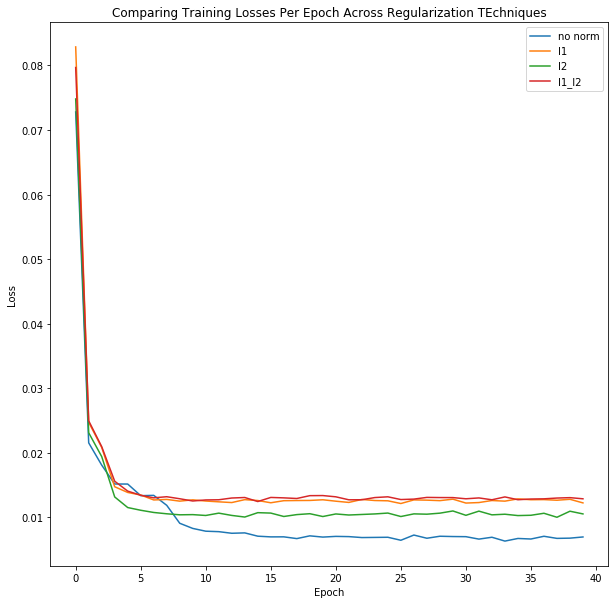

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
p=[]
q=[]
r=[]
s=[]
sum1=0.0
sum2=0.0
sum3=0.0
sum4=0.0
for i in range(0,len(train_losses)):
  if i !=0 and i!=4 and i%468 == 0:
    p.append(sum1/40)
    q.append(sum2/40)
    r.append(sum3/40)
    s.append(sum4/40)
    sum1 = 0.0
    sum2 = 0.0
    sum3 = 0.0
    sum4 = 0
  sum1 += train_losses[i]
  sum2 += train_losses_l1[i]
  sum3 += train_losses_l2[i]
  sum4 += train_losses_l1l2[i]
p = [x/40 for x in p]
q = [x/40 for x in q]
r = [x/40 for x in r]
s = [x/40 for x in s]
import matplotlib.pyplot as plt
plt.plot(p)
plt.plot(q)
plt.plot(r)
plt.plot(s)

plt.title('Comparing Training Losses Per Epoch Across Regularization TEchniques')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['no norm', 'l1', 'l2','l1_l2'], loc='best')
plt.show()

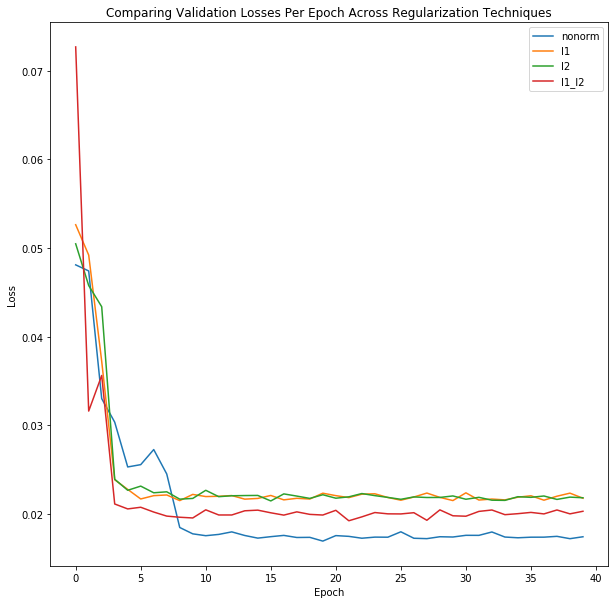

In [0]:
plt.plot(test_losses)
plt.plot(test_losses_l1)
plt.plot(test_losses_l2)
plt.plot(test_losses_l1l2)

plt.title('Comparing Validation Losses Per Epoch Across Regularization Techniques')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['nonorm', 'l1', 'l2','l1_l2'], loc='best')
plt.show()

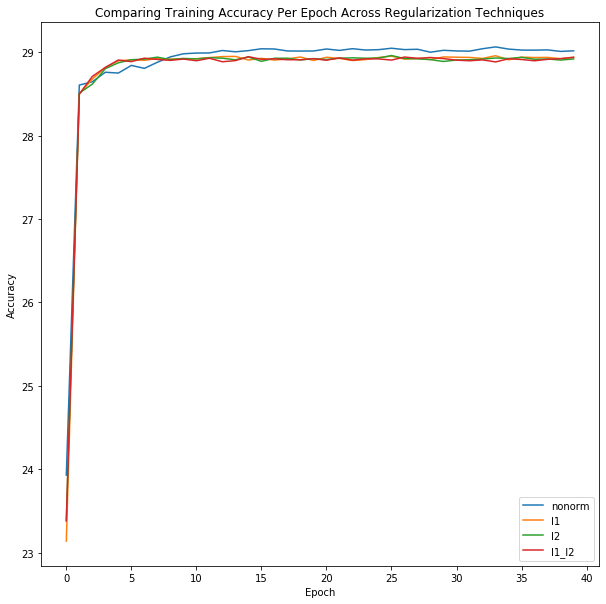

In [0]:
p=[]
q=[]
r=[]
s=[]
sum1=0.0
sum2=0.0
sum3=0.0
sum4=0.0
for i in range(0,len(train_losses)):
  if i !=0 and i!=4 and i%468 == 0:
    p.append(sum1/40)
    q.append(sum2/40)
    r.append(sum3/40)
    s.append(sum4/40)
    sum1 = 0.0
    sum2 = 0.0
    sum3 = 0.0
    sum4 = 0
  sum1 += train_acc[i]
  sum2 += train_acc_l1[i]
  sum3 += train_acc_l2[i]
  sum4 += train_acc_l1l2[i]
p = [x/40 for x in p]
q = [x/40 for x in q]
r = [x/40 for x in r]
s = [x/40 for x in s]
import matplotlib.pyplot as plt
plt.plot(p)
plt.plot(q)
plt.plot(r)
plt.plot(s)

plt.title('Comparing Training Accuracy Per Epoch Across Regularization Techniques')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['nonorm', 'l1', 'l2','l1_l2'], loc='best')
plt.show()

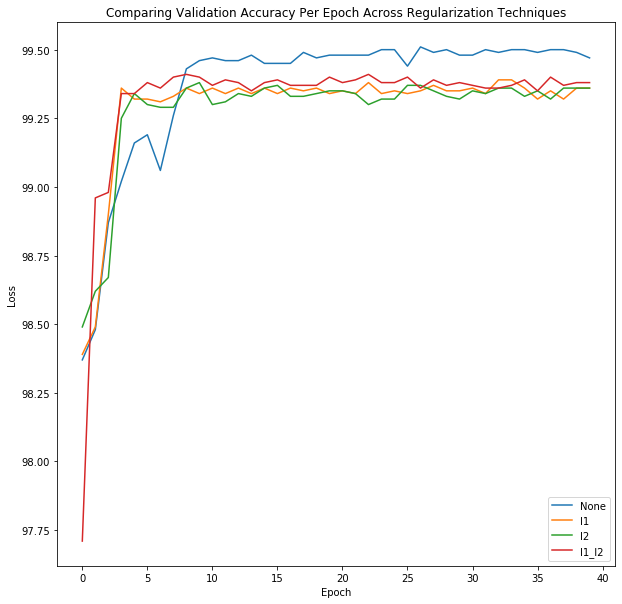

In [0]:
plt.plot(test_acc)
plt.plot(test_acc_l1)
plt.plot(test_acc_l2)
plt.plot(test_acc_l1l2)

plt.title('Comparing Validation Accuracy Per Epoch Across Regularization Techniques')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['None', 'l1', 'l2','l1_l2'], loc='best')
plt.show()

In [0]:
from torch.autograd import Variable
model_l1.eval()
correct = 0
total = 0
incorrect_examples=[]
incorrect_prediction=[]
actual_result=[]
result = []
for (i, [images, labels]) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model_l1(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)                    
    correct += (predicted == labels).sum() 
    if (predicted != labels).sum() > 0:
      idxs_mask = (predicted == labels).view(-1)
      incorrect_examples.append(images[idxs_mask==False].squeeze(1).cpu().numpy()) 
      incorrect_prediction.append(predicted[idxs_mask==False])
      actual_result.append(labels[idxs_mask==False])

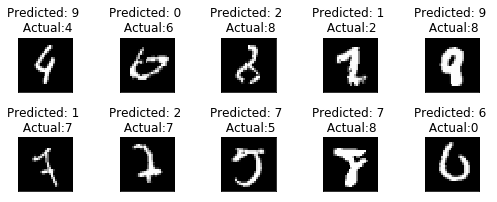

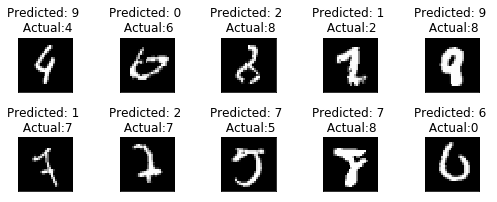

In [0]:
rcParams['figure.figsize'] = 7,7

import matplotlib.pyplot as plt
fig = plt.figure()

data, target = images.to('cpu'), labels.to('cpu')
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(incorrect_examples[i][0], cmap='gray', interpolation='none')
  plt.title("Predicted: {} \n Actual:{}".format(
    incorrect_prediction[i][0], actual_result[i][0]))
  plt.xticks([])
  plt.yticks([])
fig

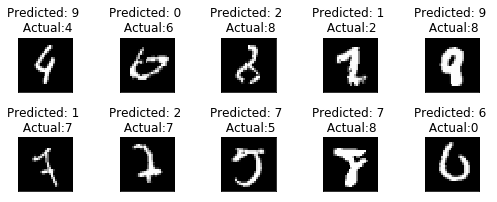

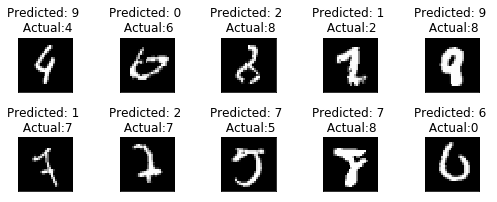

In [0]:
from torch.autograd import Variable
model_l1.eval()
correct = 0
total = 0
incorrect_examples=[]
incorrect_prediction=[]
actual_result = []
result = []
for (i, [images, labels]) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model_l2(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)                    
    correct += (predicted == labels).sum() 
    if (predicted != labels).sum() > 0:
      idxs_mask = (predicted == labels).view(-1)
      incorrect_examples.append(images[idxs_mask==False].squeeze(1).cpu().numpy()) 
      incorrect_prediction.append(predicted[idxs_mask==False])
      actual_result.append(labels[idxs_mask==False])
import matplotlib.pyplot as plt
fig = plt.figure()
data, target = images.to('cpu'), labels.to('cpu')
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(incorrect_examples[i][0], cmap='gray', interpolation='none')
  plt.title("Predicted: {} \n Actual:{}".format(
    incorrect_prediction[i][0], actual_result[i][0]))
  plt.xticks([])
  plt.yticks([])
fig